In [1]:
import os
import warnings
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import plotly
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
from random import choices
from string import ascii_lowercase, digits
import datetime
from pathlib import Path
from functools import partial
from itertools import starmap
from dotenv import load_dotenv
import requests

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import mlflow
from mlflow import MlflowClient
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.models import Model
from mlflow.data.pandas_dataset import PandasDataset

# set mlflow traking uri
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.enable_system_metrics_logging()

In [2]:
this_dir = pathlib.Path()
parent_dir = this_dir.resolve().parent
data_dir = this_dir / "data"

# create results directory, if not already existing
cwd = os.getcwd()
results_dir = os.path.join(cwd, r'baseline_results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Implement a simple recommender algorithm as linear regression

USING THE EXISTING FUNCTIONS, modify the existing train function to train a linear regression RECOMMENDER MODEL, then train/test the RECOMMENDER MODEL using the same data.

Resource: https://medium.com/intro-to-artificial-intelligence/recommendation-engine-algorithm-collaborative-filtering-d1c837eaadfb

# Eval and plotting functions

In [3]:
# MODEL EVALUATION FUNCTIONS #

def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

# Data Prep

In [4]:
# Prepare data
def data_prep(filename='training_data_cumulative.csv', features=["area"]):
# Read and log the input data 
    data_filepath = data_dir / filename
    data = pd.read_csv(data_filepath)
    data_artifact = mlflow.data.from_pandas(data)  # log when run is started
    
    
    ## DATA PREPROCESSING STEPS ##
    
    # create target column
    data["hardware_unencoded"] = list(zip(data['# of cores'], data['memory (gb)']))
    data['hardware_as_strings'] = data['hardware_unencoded'].apply(lambda x: ', '.join(map(str, x)))
    
    # encode targets
    label_encoder = LabelEncoder()
    data['hardware'] = label_encoder.fit_transform(data['hardware_as_strings'])

    
    # remove noisy features 
    feature_cols = data[features]
    df = pd.concat([feature_cols, data['hardware']], axis=1)
    
    print(df.columns)
    # Replace infty values with NaN
    df.replace(['inf', np.inf, -np.inf], np.nan, inplace=True)

    # Impute NaN values with mean
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    sample_data = df.sample(frac=0.25).dropna()
    imp_mean.fit(df)
    df = pd.DataFrame(imp_mean.fit_transform(df), columns = df.columns)
    
    # Encode categorical features
    for col_name in feature_cols.columns.tolist():
        df[col_name] = df[col_name].astype('category').cat.codes
    
    return df, data_artifact
    
    
def data_split(df, seed=None, num_samples=None, autologging=True):
    # Determine number of samples to take from data
    if num_samples is not None:
        train = df.sample(n=num_samples, random_state=seed)
        df = df[~df.index.isin(train.index)]
    else:
        train = df
    
    # Split the data into training and testing (.8, .2) split
    test_size = round(df.shape[0]*0.2)
    train_temp, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    
    return train, test

# Training

In [5]:
## DEFINE MODEL TRAINING FUNCTIONS##
# TODO: Separate preprocessing and training/evaluation

def train_recommender(train, test, data_artifact, experiment_id, seed=None, num_epochs=None, autologging=True):
    mlflow.autolog()  # enable autologging
    mlflow.sklearn.autolog()


    # The target column
    train_x = train.drop(["hardware"], axis=1)
    test_x = test.drop(["hardware"], axis=1)
    train_y = train[["hardware"]]
    test_y = test[["hardware"]]

    
    ## storage settings ##
    model_type = 'LinearRegression'
    now = datetime.datetime.now().strftime("%Y_%m_%d_%I%M%S%p")
    run_name = model_type + '_' + now
    
    
    ## MLFLOW RUN ##
    # useful for multiple runs
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True, log_system_metrics=True):
        mlflow.sklearn.autolog()
#         e_start = 1.0
#         e_decay = 0.99
        
#         for epoch in range(0, num_epochs):
#             # Decay epsilon
#             epsilon = max(e_start * e_decay, 0)
        
        # Log data
        mlflow.log_input(data_artifact, "input")
        train_dataset = mlflow.data.from_pandas(train, targets="hardware", source="data.csv")
        mlflow.log_input(train_dataset, context="training")


        # Execute recommender system
        model = LinearRegression()
        model.fit(train_x, train_y)



        # Create model artifact directory
        # cwd = os.getcwd()
        artifacts_dir = os.path.join(results_dir, run_name)
        if not os.path.exists(artifacts_dir):
            os.makedirs(artifacts_dir)
            
            
        # SET AND LOG PARAMETERS # 
        # (some model parameters will be autologged mlflow but not optuna)
        mlflow.log_param("model_seed", seed)
        


        ## IF AUTOLOGGING IS NOT ENABLED ##
        if autologging==False:
            
            # Log and download artifacts locally --- file upload not yet supported in NDP JupyterHub
            active_run = mlflow.active_run()
            mlflow.artifacts.download_artifacts(run_id = active_run.info.run_id, dst_path=artifacts_dir)
            mlflow.sklearn.log_model(sk_model=lr, input_example=test_x, artifact_path=artifacts_dir)
        
       
    # log runtime


    mlflow.end_run()   # END CURRENT RUN BEFORE STARTING NEW RUN

In [6]:
def get_best_model(experiment_id=None):
    
    # Opt. for now: get best run
    best_run = mlflow.search_runs(
        experiment_id, order_by=["metrics.eval_rmse"], max_results=1
    )
    print(best_run.info)
    
    return None

# Run experiments

In [7]:
## EXPERIMENT FUNCTION ##
def run_experiment(num_runs=10, train_func=train_recommender, num_samples=None, num_epochs=None, experiment_name=None):
    
    
    # Generate experiment name
    random_suffix = "".join(choices(ascii_lowercase, k=2)+choices(digits, k=3))
    experiment_name = 'Recommender_'+random_suffix
        
    # create experiment (if not existing)
    try:
        mlflow.create_experiment(experiment_name)
    except:
        pass
    
    mlflow.set_experiment(experiment_name)

    
    # Get experiment ID
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    
    # prep data
#     df, data_artifact = data_prep(features=["area", "run_max_mem_rss_bytes", "sim_time"])
    df, data_artifact = data_prep(features=['canopy_moisture','surface_moisture','threads','wind_direction','wind_speed'])
    
    # Run experiments on train and test data
    
    for i in range(num_runs):
        # Generate random seed
        #warnings.filterwarnings("ignore")
        np_max_int = np.iinfo(np.int32).max
        seed = np.random.randint(np_max_int)
        np.random.seed(seed)
        
        # Generate train and test data
        train, test = data_split(df, num_samples=num_samples, seed=seed)
        
        # train recommender
        train_recommender(train, test, data_artifact, experiment_id, seed=seed)
        
    
    
    return experiment_id

In [8]:
# experiment = run_experiment(num_runs=100)

In [9]:
# get_best_model(experiment)

In [10]:
experiment_fewer_data = run_experiment(num_runs=100, num_samples=25)

2024/12/10 17:04:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


Index(['canopy_moisture', 'surface_moisture', 'threads', 'wind_direction',
       'wind_speed', 'hardware'],
      dtype='object')


2024/12/10 17:04:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/12/10 17:04:08 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/12/10 17:04:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/12/10 17:04:09 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Failed to infer schema for pandas.Series 0       (2, 16)
1       (2, 16)
2       (2, 16)
3       (2, 16)
4       (2, 16)
         ...   
1369    (4, 16)
1370    (4, 16)
1371    (4, 16)
1372    (4, 16)
1373    (4, 16)
Name: hardware_unencoded, Length: 1374, dtype: object. Error: Data (2, 16) is not one of the supported DataType
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specif

2024/12/10 17:04:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:13 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:13 INFO mlflow.system_me

2024/12/10 17:04:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:17 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:17 INFO mlflow.system_me

2024/12/10 17:04:19 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:22 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:22 INFO mlflow.system_me

2024/12/10 17:04:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:26 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:26 INFO mlflow.system_me

2024/12/10 17:04:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:31 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:31 INFO mlflow.system_me

2024/12/10 17:04:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:35 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:35 INFO mlflow.system_me

2024/12/10 17:04:37 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:40 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:40 INFO mlflow.system_me

2024/12/10 17:04:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:45 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:45 INFO mlflow.system_me

2024/12/10 17:04:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:49 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:49 INFO mlflow.system_me

2024/12/10 17:04:51 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:54 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:54 INFO mlflow.system_me

2024/12/10 17:04:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:04:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:04:59 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:04:59 INFO mlflow.system_me

2024/12/10 17:05:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:05:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:05:03 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:05:03 INFO mlflow.system_me

2024/12/10 17:05:05 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:05:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:05:08 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:05:08 INFO mlflow.system_me

2024/12/10 17:05:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:05:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:05:12 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:05:12 INFO mlflow.system_me

2024/12/10 17:05:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:05:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:05:17 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:05:17 INFO mlflow.system_me

2024/12/10 17:05:19 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:05:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:05:22 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:05:22 INFO mlflow.system_me

2024/12/10 17:05:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:05:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:05:26 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:05:26 INFO mlflow.system_me

2024/12/10 17:05:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:05:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:05:31 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:05:31 INFO mlflow.system_me

2024/12/10 17:05:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:05:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:05:36 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:05:36 INFO mlflow.system_me

2024/12/10 17:05:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

2024/12/10 17:05:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/10 17:05:40 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/10 17:05:40 INFO mlflow.system_me

In [11]:
best_model = get_best_model(experiment_fewer_data)

<bound method DataFrame.info of                              run_id       experiment_id    status  \
0  25d5dd987dcb442488f4e210f6a3515b  913523715010613541  FINISHED   

                                        artifact_uri  \
0  mlflow-artifacts:/913523715010613541/25d5dd987...   

                        start_time                         end_time  \
0 2024-12-11 01:05:41.724000+00:00 2024-12-11 01:05:42.577000+00:00   

   metrics.training_mean_squared_error  \
0                             0.496826   

   metrics.training_root_mean_squared_error  metrics.training_r2_score  \
0                                  0.704859                   0.102554   

   metrics.training_score  ...  params.copy_X params.fit_intercept  \
0                0.102554  ...           True                 True   

  params.model_seed                      tags.mlflow.log-model.history  \
0          32220283  [{"run_id": "25d5dd987dcb442488f4e210f6a3515b"...   

                             tags.mlflow.source.n

In [12]:
df_runs = mlflow.search_runs(experiment_fewer_data, max_results=100)

In [13]:
rmse = df_runs["metrics.training_root_mean_squared_error"]

In [14]:
df_runs.describe()

,metrics.training_mean_squared_error,metrics.training_root_mean_squared_error,metrics.training_r2_score,metrics.training_score,metrics.training_mean_absolute_error
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.535752,0.728040,0.125672,0.125672,0.616175
std,0.108418,0.075951,0.109600,0.109600,0.085438
min,0.225842,0.475228,0.004281,0.004281,0.406685
25%,0.464546,0.681575,0.049443,0.049443,0.560311
50%,0.522278,0.722688,0.090603,0.090603,0.609910
75%,0.618578,0.786497,0.184639,0.184639,0.680921
max,0.753288,0.867922,0.579907,0.579907,0.787355


In [15]:
df_runs['duration'] = [(df_runs['end_time'][x] - df_runs['start_time'][x]).total_seconds() for x in range(0, df_runs.shape[0])]

<Axes: title={'center': 'RMSE for linear regression model'}>

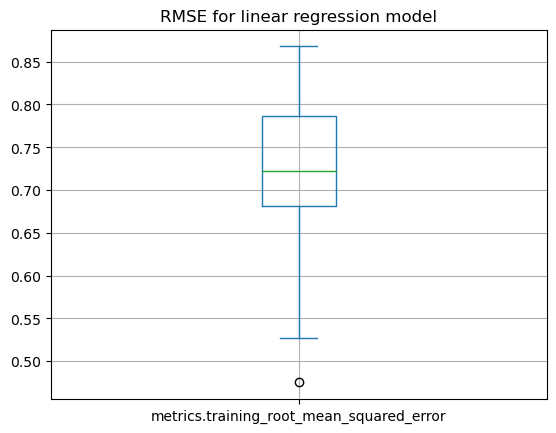

In [16]:
df_runs['metrics.training_root_mean_squared_error'].plot(kind='box', title='RMSE for linear regression model', grid=True) 

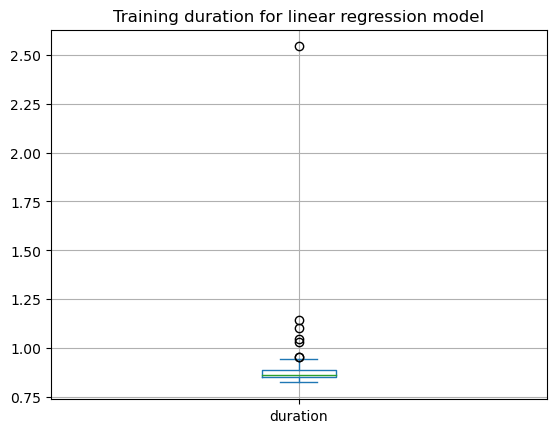

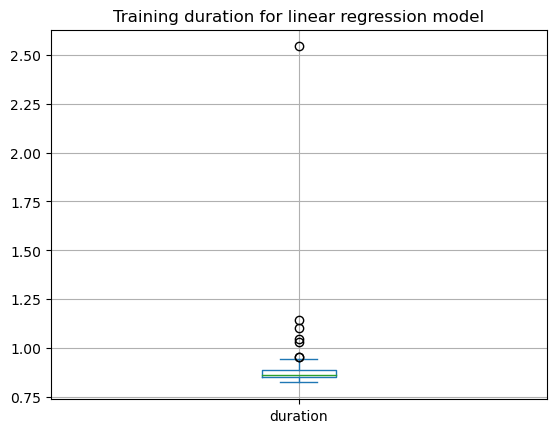

In [17]:
df_runs['duration'].plot(kind='box', title='Training duration for linear regression model', grid=True).get_figure()
